# Various Experiments #1

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import lib.calc as c
import scipy.ndimage as nd
from skimage import filters, measure, exposure, feature, color

Read some data, use `lib.calc.read_kmap` to do so.

In [26]:
# init stuff
sf = '/data/id01/inhouse/IHR/HC3313/spec/e17089_fast_00022.spec'
rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']

In [27]:
s10 = c.read_kmap(sf, 10, rois_103)
s15 = c.read_kmap(sf, 21, rois_103)

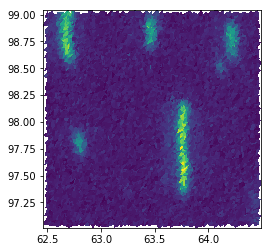

In [28]:
data = s10['roi2'][2].T[::-1]
plt.pcolormesh(s10['roi2'][0],s10['roi2'][1],s10['roi2'][2])
plt.axis('image');

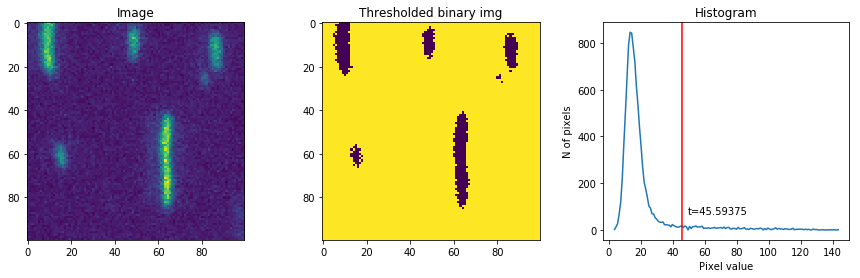

In [29]:
%matplotlib inline
# establish threshold for binarisation
threshold = filters.threshold_otsu(data,nbins=int(data.max()))
# calc image historgram to see where threshold lies
hist, bins_centre = exposure.histogram(data,nbins=int(data.max()))
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))
ax1.set_title('Image')
ax1.imshow(data)
ax2.set_title('Thresholded binary img')
ax2.imshow(data<threshold)
ax3.set_title('Histogram')
ax3.plot(bins_centre, hist)
ax3.set_xlabel('Pixel value')
ax3.set_ylabel('N of pixels')
ax3.annotate('t={0}'.format(threshold),[threshold,hist.mean()],xytext=[threshold+4,hist.mean()])
ax3.axvline(threshold, c='r');

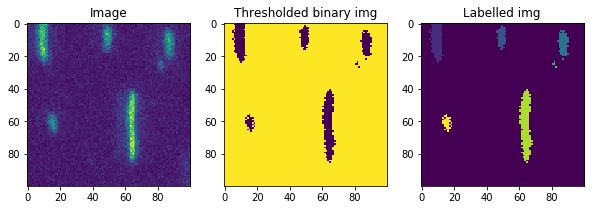

In [30]:
# label individual regions
data_labels = measure.label(data<threshold,background=1)
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
ax1.set_title('Image')
ax1.imshow(data)
ax2.set_title('Thresholded binary img')
ax2.imshow(data<threshold)
ax3.set_title('Labelled img')
ax3.imshow(data_labels);

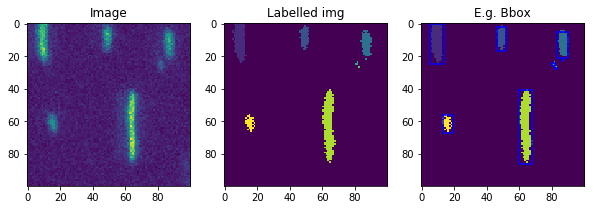

In [31]:
# measure properties of labelled regions
regions = measure.regionprops(data_labels)
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
ax1.set_title('Image')
ax1.imshow(data)
ax2.set_title('Labelled img')
ax2.imshow(data_labels)
ax3.set_title('E.g. Bbox')
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    
    ax3.imshow(data_labels)
    ax3.plot(bx, by, '-b', linewidth=1.5)

In [32]:
prop1 = regions[0]
minr, minc, maxbr, maxc = prop1.bbox

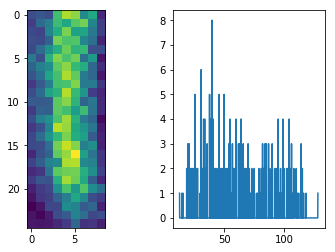

In [33]:
rdata = data[minr:maxbr,minc:maxc]
fig, ax = plt.subplots(1,2)
ax[0].imshow(rdata)
hist, bins_centre = exposure.histogram(rdata,nbins=1024)
ax[1].plot(bins_centre,hist)

### Cross-correlation

Detected subpixel offset (y, x): [ 7.  9.]


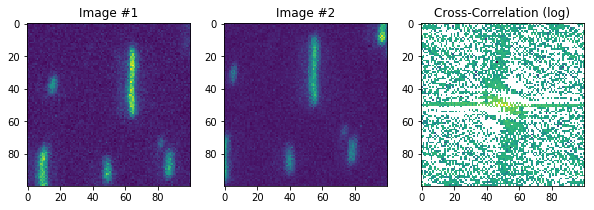

In [34]:
# calc phase correlation between two adjacent scans with pixel precision
im1 = s10['roi2'][2].T
im2 = s15['roi2'][2].T
shift, error, diffphase = feature.register_translation(im1,im2) # add ,100 for subpixel
# mimick algorithm for illustration purposes
image_product = np.fft.fft2(im1) * np.fft.fft2(im2).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(im2))
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
ax1.set_title('Image #1')
ax1.imshow(im1)
ax2.set_title('Image #2')
ax2.imshow(im2)
ax3.set_title('Cross-Correlation (log)')
ax3.imshow(np.log(cc_image.real))
print("Detected subpixel offset (y, x): {}".format(shift));

### Finding the window with `ndimage`

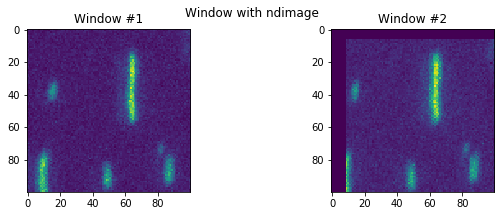

In [35]:
from scipy.ndimage import shift as ndshift

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Window with ndimage')
ax1.set_title('Window #1')
ax1.imshow(im1)
ax2.set_title('Window #2')
ax2.imshow(ndshift(im2,shift));

### Finding the max window

Disadvantage: the images change size

(93, 91) (93, 91)


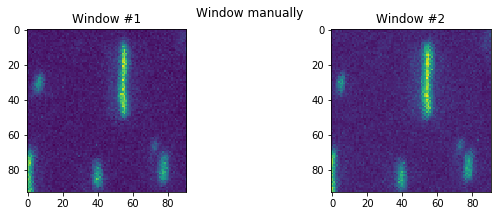

In [36]:
y = int(shift[0])
x = int(shift[1])

window1 = im1[y:,x:]
window2 = im2[:im2.shape[0]-y,:im2.shape[1]-x]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Window manually')
ax1.set_title('Window #1')
ax1.imshow(window1)
ax2.set_title('Window #2')
ax2.imshow(window2)

print(window1.shape, window2.shape)

### Comparing the properties of the two shift corrected images

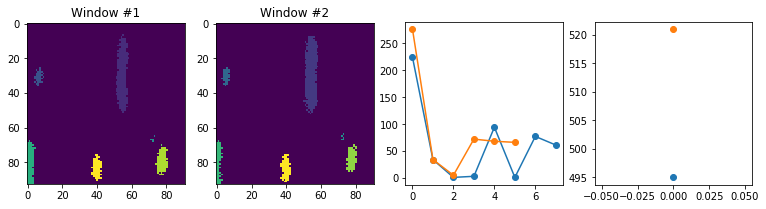

In [37]:
# Calc thresholded data
tdata1 = window1 < filters.threshold_otsu(window1)
tdata2 = window2 < filters.threshold_otsu(window2)
# Label it
labels1 = measure.label(tdata1,background=1)
labels2 = measure.label(tdata2,background=1)
# Measure it
regions1 = measure.regionprops(labels1)
regions2 = measure.regionprops(labels2)

areas1, areas2 = [], []
for region in regions1:
    areas1.append(region.area)
for region in regions2:
    areas2.append(region.area)
    
totarea1 = np.array(areas1).sum()
totarea2 = np.array(areas2).sum()

# Plot it
fig, ax = plt.subplots(1,4,figsize=(13,3))

ax[0].imshow(labels1)
ax[0].set_title('Window #1')

ax[1].imshow(labels2)
ax[1].set_title('Window #2')

ax[2].plot(areas1,marker='o')
ax[2].plot(areas2,marker='o')

ax[3].plot(totarea1,marker='o')
ax[3].plot(totarea2,marker='o')

plt.show()

# Multiple images

Read the data and store it in the `small_1` dictionary. Access the intensity by calling `small_1[<scan_no>]['<roi>'][2]`.

In [38]:
sf = '/data/id01/inhouse/IHR/HC3313/spec/e17089_fast_00022.spec'
rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']
scan_list = [10,15,21,27,33,39,45,51,57,63,69,75,80,85,90]

small_1 = dict()
for scan in scan_list:
    small_1[scan] = c.read_kmap(sf, scan, rois_103) # out is piy, pix, int per each roi

Define a function to calc and correct the shift between two images. Use the `register_translation` function to do so, and shift the image with `ndimage.shift` function. Fill in the shifted image remaining areas with 0s, do not use spline interpolation (see [here](http://lagrange.univ-lyon1.fr/docs/scipy/0.17.1/generated/scipy.ndimage.shift.html))

In [39]:
def correct_shift_nd(im1, im2):
    # calc shift
    shift, error, diffphase = feature.register_translation(im1,im2) # add ,100 for subpixel
    print(shift)
    win2 = ndshift(im2,shift,order=0)
    
    return win2

Do the same but "manually"; the shift is corrected by selecting the window that overlaps the two images. This changes the image size, in contrast with the previous method.

In [40]:
def correct_shift(im1, im2):
    # calc shift between adjacent imgs
    shift, error, diffphase = feature.register_translation(im1,im2) # add ,100 for subpixel
    print(shift)
    y = int(shift[0])
    x = int(shift[1])

    # make max window
    if x >= 0:
        window1 = im1[y:,x:]
        window2 = im2[:im2.shape[0]-y,:im2.shape[1]-x]
    else:
        window2 = im2[y:,abs(x):]
        window1 = im1[:im2.shape[0]-y,:im2.shape[1]-abs(x)]
    
    return window1, window2

Prepare data:

In [41]:
small_1_roi2 = []
for scan in scan_list:
    small_1_roi2.append(small_1[scan]['roi2'][2]) # list of roi2 intensity ndarrays

Manual. Output: `windows`

In [42]:
windows = []
for index in range(1,len(small_1_roi2)):
    win1, win2 = correct_shift(small_1_roi2[index-1], small_1_roi2[index])
    windows.append(win1)
    if index == len(small_1_roi2)-1:
        windows.append(win2)

[ 4.  2.]
[ 5.  5.]
[-4.  2.]
[ 8.  0.]
[-4.  1.]
[ 0.  6.]
[ 5.  0.]
[ 4.  1.]
[-2.  0.]
[ 3.  1.]
[-1.  1.]
[ 0.  2.]
[-9.  0.]
[-3.  2.]


`ndimage`. Output: `windows`.

In [43]:
windows = []
for index in range(1,len(small_1_roi2)):
    # first iter
    if index == 1:
        windows.append(small_1_roi2[index-1])
        win2 =  correct_shift_nd(small_1_roi2[index-1], small_1_roi2[index])
        windows.append(win2)
    # second iter
    else:
        win2 = correct_shift_nd(windows[index-1], small_1_roi2[index])
        windows.append(win2)

[ 4.  2.]
[ 9.  7.]
[ 5.  9.]
[ 13.   9.]
[  9.  10.]
[  9.  17.]
[ 14.  17.]
[ 18.  18.]
[ 16.  18.]
[ 19.  18.]
[ 18.  18.]
[ 18.  19.]
[ 10.  19.]
[  8.  21.]


### The one that makes most sense:
`ndimage` all wrt to the first image:

In [44]:
windows = []
for index in range(1,len(small_1_roi2)):
    if index == 1:
        windows.append(small_1_roi2[0]) # first img
        win2 = correct_shift_nd(small_1_roi2[0],small_1_roi2[index])
        windows.append(win2)
    else:
        win2 = correct_shift_nd(small_1_roi2[0],small_1_roi2[index])
        windows.append(win2)                   

[ 4.  2.]
[ 9.  7.]
[ 4.  9.]
[ 13.  10.]
[  9.  12.]
[  9.  20.]
[ 14.  19.]
[ 17.  20.]
[ 15.  20.]
[ 19.  22.]
[ 17.  24.]
[ 17.  28.]
[  9.  32.]
[  6.  37.]


Restrict the visible window to the largest displacement in x and y, and inspect the images:

In [45]:
voltages = [5,10,20,30,40,50,60,70,-10,-20,-30,-40,-50,-60,-70,100,150]

In [47]:
from ipywidgets import interact

shifts = []
for index in range(1,len(small_1_roi2)):
    shift, whatev, whatevs = feature.register_translation(small_1_roi2[0],small_1_roi2[index])
    shifts.append(shift)

shifts = np.array(shifts)

y_max = int(shifts[:,0].max())
x_max = int(shifts[:,1].max())

print('max shift in y: {0} \nmax shift in x: {1}'.format(y_max,x_max))

winidx = np.s_[y_max:,x_max:]
piy_win = small_1[scan_list[0]]['roi1'][0][winidx]
pix_win = small_1[scan_list[0]]['roi1'][1][winidx]

@interact(i=(0, len(windows)-1))
def plot(i=0):
    plt.imshow(windows[i][winidx].T[::-1], extent=(piy_win.min(),piy_win.max(),pix_win.min(),pix_win.max()))
    plt.title('{0} V'.format(voltages[i]))
    plt.ylabel('pix')
    plt.xlabel('piy')
#     plt.pcolormesh(piy_win,pix_win,windows[i][winidx])
#     plt.axis('image')

max shift in y: 19 
max shift in x: 37


interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',))

Calc the areas:

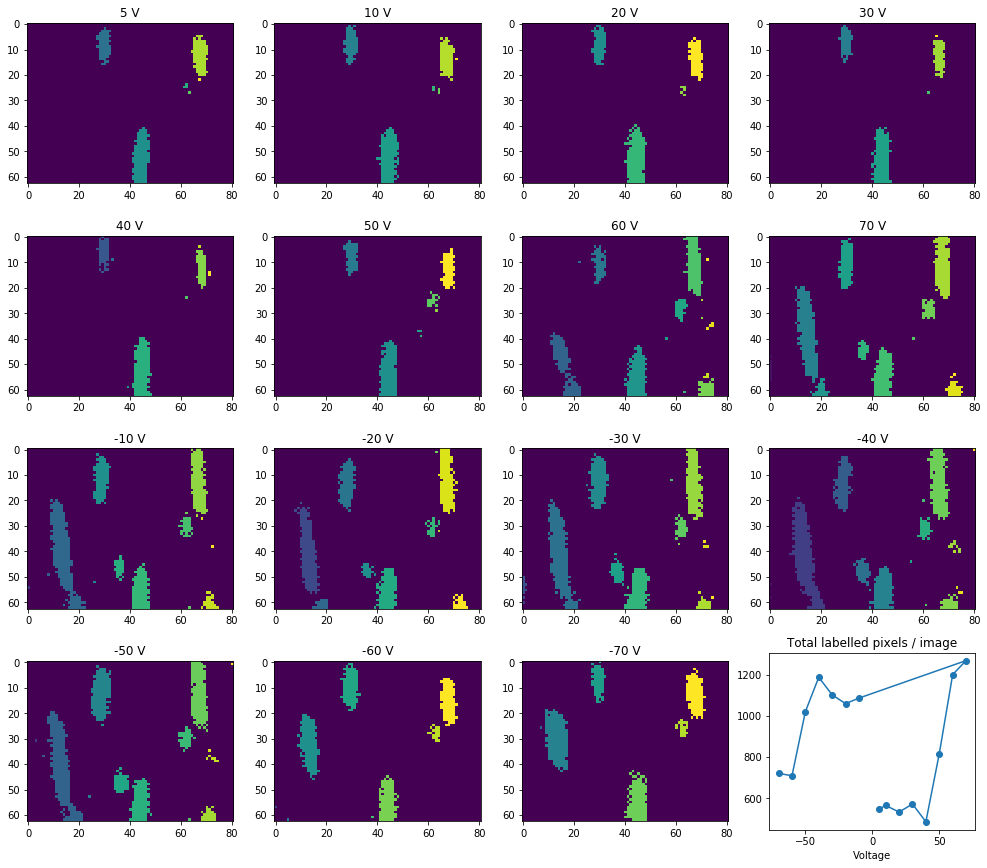

In [48]:
fig, ax = plt.subplots(4,4,figsize=(17,15))
axes = ax.ravel()

tot_areas = []
for index,img in enumerate(windows):
    thresholded_img = img < filters.threshold_otsu(img)
    labelled_img = measure.label(thresholded_img,background=1)
    regions = measure.regionprops(labelled_img)
    
    axes[index].imshow(labelled_img[winidx].T[::-1])
    axes[index].set_title('{0} V'.format(voltages[index]))
    
    areas = []
    for region in regions:
        areas.append(region.area)
    totarea = np.array(areas).sum()
    
    tot_areas.append(totarea)
    
axes[len(axes)-1].plot(voltages[:len(voltages)-2],tot_areas,marker='o')
axes[len(axes)-1].set_title('Total labelled pixels / image')
axes[len(axes)-1].set_xlabel('Voltage')
# axes[len(axes)-1].set_ylabel('Area')
plt.show()

What's different between this one and what's in the "final" notebook?